# Assignment #1

## Overview of our assignment
* Given a face image dataset, namely CelebA, you need to perform classification with it, using an MLP and multiple CNN architectures, and then report the results.
* We provide three models for classification, such as MLP, VGG, and ResNet-18, which can be used as the base architectures for your assignment.
* You should use the following three regularization techniques: 1) Dropout, 2) L2 normalization, and 3) L1 normalization, based upon the provided three models, and then report the results with regularization techniques that you will implement. 
* Also, you should apply the following three optimization methods: 1) SGD with Momentum, 2) AdaGrad, and 3) Adam, and then report the obtained results as well.

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

## Preparing the CelebA dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

Download link: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8

1) Download and unzip the file `./Img/img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `./Anno/list_attr_celeba.txt` file, which contains the class labels.

3) Download the `./Eval/list_eval_partition.txt` file, which contains  training/validation/test partitioning info.

Please make sure that, all your downloaded files (or unzipped folders) are located inside of the "./data" folder to run below codes.

For example,
* ./data/list_attr_celeba.txt
* ./data/list_eval_partition.txt
* ./data/img_align_celeba/{IMAGE_NAME}.jpg

In [2]:
df1 = pd.read_csv('./data/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0
df1.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


In [3]:
df2 = pd.read_csv('./data/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.head()

,Partition
Filename,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [4]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [5]:
df3.to_csv('./data/celeba-gender-partitions.csv')
df4 = pd.read_csv('./data/celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [6]:
df4.loc[df4['Partition'] == 0].to_csv('./data/celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('./data/celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('./data/celeba-gender-test.csv')

(218, 178, 3)


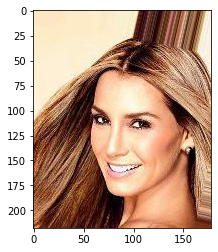

In [7]:
# Print sample image
img = Image.open('./data/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

## Implementing the DataLoader for training, validation, and test

In [8]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [9]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((32, 32)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='./data/celeba-gender-train.csv',
                              img_dir='./data/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='./data/celeba-gender-valid.csv',
                              img_dir='./data/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='./data/celeba-gender-test.csv',
                             img_dir='./data/img_align_celeba/',
                             transform=custom_transform)

BATCH_SIZE=256


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=12)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=12)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=12)

In [10]:
# Testing dataloader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 256
Epoch: 2 | Batch index: 0 | Batch size: 256


## Implementing models

In [11]:
# Hyperparameters
random_seed = 42
learning_rate = 0.001
num_epochs = 50
l_lambda = 0.01 #1e-5

# Architecture
num_features = 32*32
num_classes = 2

In [12]:
from models import mlp
from models import vgg
from models import resnet

In [24]:
# You need to specify the model that you want to use in here.

model = mlp.MLP()                 # For MLP
# model = mlp.MLP(drop=0.5)         # For MLP with Dropout
# model = vgg.VGG16()               # For VGG
# model = resnet.ResNet18()         # For ResNet18

model = model.to(device)

In [25]:
# You need to implement optimizers for this assignment,
# Note that you can directly load the optimizer that you want to use in PyTorch library

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=l_lambda)  #L2 regularization
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [26]:
#For visualization
train_loss=[]
train_acc=[]
valid_acc=[]
l1_norms=[]
l2_norms=[]

In [27]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        l1_norm = sum(torch.norm(param, p=1) for param in model.parameters())
        l2_norm = sum(torch.norm(param) for param in model.parameters())
        
        ### L1 regularization
        # cost += l_lambda * l1_norm
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        '''
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
        '''
    
    train_loss.append(cost)
    l1_norms.append(l1_norm)
    l2_norms.append(l2_norm)

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc.append(compute_accuracy(model, train_loader))
        valid_acc.append(compute_accuracy(model, valid_loader))
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, num_epochs, 
              train_acc[-1],
              valid_acc[-1]))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Train: 90.322% | Valid: 91.297%
Time elapsed: 0.55 min
Epoch: 002/050 | Train: 90.586% | Valid: 92.042%
Time elapsed: 1.10 min
Epoch: 003/050 | Train: 89.821% | Valid: 91.176%
Time elapsed: 1.65 min
Epoch: 004/050 | Train: 93.411% | Valid: 94.342%
Time elapsed: 2.20 min
Epoch: 005/050 | Train: 92.922% | Valid: 93.673%
Time elapsed: 2.75 min
Epoch: 006/050 | Train: 93.998% | Valid: 94.881%
Time elapsed: 3.30 min
Epoch: 007/050 | Train: 93.325% | Valid: 94.171%
Time elapsed: 3.85 min
Epoch: 008/050 | Train: 93.466% | Valid: 94.242%
Time elapsed: 4.40 min
Epoch: 009/050 | Train: 94.544% | Valid: 95.097%
Time elapsed: 4.94 min
Epoch: 010/050 | Train: 94.409% | Valid: 94.961%
Time elapsed: 5.49 min
Epoch: 011/050 | Train: 94.536% | Valid: 95.047%
Time elapsed: 6.04 min
Epoch: 012/050 | Train: 94.975% | Valid: 95.228%
Time elapsed: 6.59 min
Epoch: 013/050 | Train: 94.018% | Valid: 94.458%
Time elapsed: 7.14 min
Epoch: 014/050 | Train: 95.207% | Valid: 95.425%
Time elapsed: 7

## Evaluation

In [28]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.94%


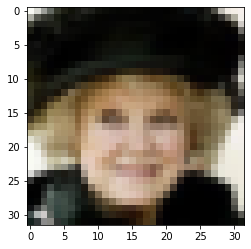

In [29]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [30]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 99.48%


## Visualization

You need to draw training curves of your models, and then insert the curves as well as the final results of your model in your report.

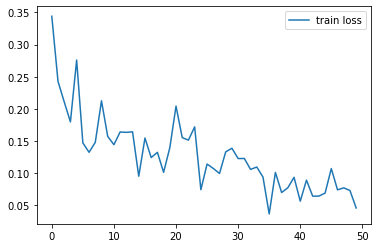

In [31]:
plt.plot(train_loss, label='train loss')
plt.legend()

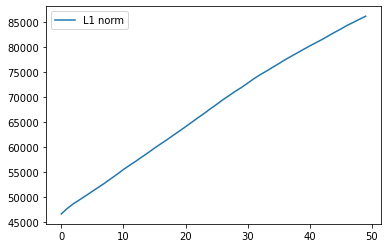

In [32]:
plt.plot(l1_norms, label='L1 norm')
plt.legend()

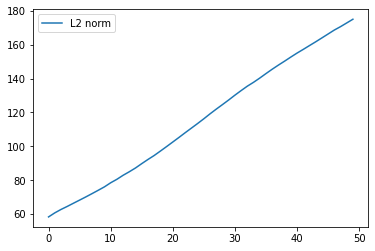

In [33]:
plt.plot(l2_norms, label='L2 norm')
plt.legend()

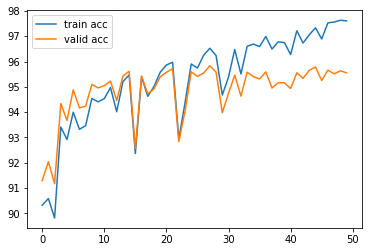

In [34]:
plt.plot(train_acc, label='train acc')
plt.plot(valid_acc, label='valid acc')
plt.legend()